![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

## Case study 2: Hello worlds. Run two models on the same forcing data and compare output (discharge)
This notebooks demonstrates how to use models in eWaterCycle by showing how to run two different models for the same region (Merrimack) and on the same forcing data (ERA5: 1990).

The models used in this notebook are:

- WFlow (Schellekens et. al. 2020, [https://doi.org/10.5281/ZENODO.593510](https://doi.org/10.5281/ZENODO.593510))
- LISFLood (van der Kneijf et. al. 2010, [https://doi.org/10.1080/13658810802549154](https://doi.org/10.1080/13658810802549154))

The pre-processing (ie. generating forcing data) for this experiment was already done. For information on how to generate forcing data for a given combination of model, forcing dataset and time period, see the notebook titled `Case1_Marrmot_Merrimack_ESMValTool` in this repo.

## Import statements
We'll be using the following modules

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
from cartopy.io import shapereader

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.analysis
import ewatercycle.observation.grdc

## Observation

In [2]:
# Get grdc observations at 4147380 station related to Merrimack
df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id="4147380",
    start_time="1990-01-01T00:00:00Z",
    end_time="1990-12-31T00:00:00Z",
)

# Get lat/lon of the station
station_lat = [metadata["grdc_latitude_in_arc_degree"]]
station_lon = [metadata["grdc_longitude_in_arc_degree"]]

# Convert it to dataframe and rename it to GRDC
observations = df.rename(columns={"streamflow": "GRDC"})
observations

GRDC station 4147380 is selected. The river name is: MERRIMACK RIVER.The coordinates are: (42.6459, -71.2984).The catchment area in km2 is: 12004.7. There are 0 missing values during 1990-01-01T00:00:00Z_1990-12-31T00:00:00Z at this station. See the metadata for more information.


,GRDC
time,
1990-01-01,119.214
1990-01-02,136.204
1990-01-03,131.107
1990-01-04,133.655
1990-01-05,139.035
...,...
1990-12-27,668.276
1990-12-28,512.534
1990-12-29,419.089


## Wflow

### Load forcing data
Here we use pre-generated forcing data. Although data is available for 1990-2001, we will only need the first year.

In [3]:
forcing = ewatercycle.forcing.load('/mnt/data/forcing/wflow_ERA5_1990-2001_merrimack')
print(forcing)

Forcing data for Wflow
----------------------
Directory: /mnt/data/forcing/wflow_ERA5_1990-2001_merrimack
Start time: 1990-01-01T12:00:00Z
End time: 2001-12-31T12:00:00Z
Shapefile: None
Additional information for model config:
  - netcdfinput: wflow_ERA5_Merrimack_1990_2001.nc
  - Precipitation: /pr
  - Temperature: /tas
  - EvapoTranspiration: /pet
  - Inflow: None


### Load parameterset

In [4]:
parameterset = ewatercycle.parameter_sets.get_parameter_set('wflow_merrimack_techpaper')
print(parameterset)

Parameter set
-------------
name=wflow_merrimack_techpaper
directory=/mnt/data/parameter-sets/wflow_merrimack_techpaper
config=/mnt/data/parameter-sets/wflow_merrimack_techpaper/wflow_sbm_era5_test.ini
doi=N/A
target_model=wflow
supported_model_versions={'2020.1.1'}


### Set up the model

In [6]:
ewatercycle.models.Wflow.available_versions

('2020.1.1',)

In [7]:
model = ewatercycle.models.Wflow(version='2020.1.1', parameter_set=parameterset, forcing=forcing)

Config file from parameter set is missing RiverRunoff option in API section, added it with value '2, m/s option'


Forcing time range is 1990-2001, but we want to run the model for the year 1990, so set `end_time` in setup() function:

In [8]:
cfg_file, cfg_dir = model.setup(end_time='1990-12-31T00:00:00Z')
print(cfg_file)
print(cfg_dir)

Running /mnt/data/singularity-images/ewatercycle-wflow-grpc4bmi_2020.1.1.sif singularity container on port 48023
/mnt/home/user37/technicalPaperExampleNotebooks/ewatercycle_output/wflow_20210826_163223/wflow_ewatercycle.ini
/mnt/home/user37/technicalPaperExampleNotebooks/ewatercycle_output/wflow_20210826_163223


In [9]:
# Initialize
model.initialize(cfg_file)

In [10]:
# Get metadata
model.output_var_names

('SurfaceRunoff', 'RiverRunoff')

### Run the model

We store discharge and time values. For time, only date part is kept using the function `date()`. So, we can create a dataframe joining the data on date later for the hydrograph. Wflow has steps at noon, while GRDC and lisflood uses midnight.

In [11]:
discharge = []
time_range = []

while model.time < model.end_time:
    model.update()
    # Get Discharge at one location
    discharge_at_pixel = model.get_value_at_coords('RiverRunoff', lon=station_lon, lat=station_lat)[0]
    discharge.append(discharge_at_pixel)
    time_range.append(model.time_as_datetime.date())
    print(model.time_as_isostr, end="\r")

In [12]:
# Stop the model
model.finalize()

In [13]:
# Concatenate timeseries
wflow = pd.DataFrame({'wflow': discharge}, index=pd.to_datetime(time_range))
wflow

,wflow
1990-01-01,502.869934
1990-01-02,501.310394
1990-01-03,467.357941
1990-01-04,422.030151
1990-01-05,379.955841
...,...
1990-12-27,590.317139
1990-12-28,511.656464
1990-12-29,450.715698
1990-12-30,447.656281


## Lisflood

### Load forcing data
Pre-generated lisflood forcing data is available for the year 1990. It is a global file, where all but the Merrimack catchment (and a few others that are irrelevant for this example) are masked.

In [14]:
forcing = ewatercycle.forcing.load('/mnt/data/forcing/lisflood_ERA5_1990_global-masked')
print(forcing)

eWaterCycle forcing
-------------------
start_time=1990-01-01T12:00:00Z
end_time=1990-12-31T12:00:00Z
shape=None
PrefixPrecipitation=lisflood_ERA5_pr_1990_1990.nc
PrefixTavg=lisflood_ERA5_tas_1990_1990.nc
PrefixE0=lisflood_ERA5_e0_1990_1990.nc
PrefixES0=lisflood_ERA5_es0_1990_1990.nc
PrefixET0=lisflood_ERA5_et0_1990_1990.nc
directory=/mnt/data/forcing/lisflood_ERA5_1990_global-masked


### Load parameter set

In [15]:
parameterset = ewatercycle.parameter_sets.get_parameter_set('lisflood_global-masked_01degree')
print(parameterset)

Parameter set
-------------
name=lisflood_global-masked_01degree
directory=/mnt/data/parameter-sets/lisflood_global-masked_01degree
config=/mnt/data/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xml
doi=N/A
target_model=lisflood
supported_model_versions=set()


### Set up the model

In [16]:
ewatercycle.models.Lisflood.available_versions

('20.10',)

In [17]:
model = ewatercycle.models.Lisflood(version='20.10', parameter_set=parameterset, forcing=forcing)
print(model)

Model version 20.10 is not explicitly listed in the supported model versions of this parameter set. This can lead to compatibility issues.
eWaterCycle Lisflood
-------------------
Version = 20.10
Parameter set = 
  Parameter set
  -------------
  name=lisflood_global-masked_01degree
  directory=/mnt/data/parameter-sets/lisflood_global-masked_01degree
  config=/mnt/data/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xml
  doi=N/A
  target_model=lisflood
  supported_model_versions=set()
Forcing = 
  eWaterCycle forcing
  -------------------
  start_time=1990-01-01T12:00:00Z
  end_time=1990-12-31T12:00:00Z
  shape=None
  PrefixPrecipitation=lisflood_ERA5_pr_1990_1990.nc
  PrefixTavg=lisflood_ERA5_tas_1990_1990.nc
  PrefixE0=lisflood_ERA5_e0_1990_1990.nc
  PrefixES0=lisflood_ERA5_es0_1990_1990.nc
  PrefixET0=lisflood_ERA5_et0_1990_1990.nc
  directory=/mnt/data/forcing/lisflood_ERA5_1990_global-masked


In [18]:
# Lisflood requires a mask map, in this case only the Merrimack is unmasked
model_mask = 'settingFiles/lisflood_model_mask.nc'

config_file, config_dir = model.setup(end_time='1990-12-31T00:00:00Z', MaskMap=model_mask)
print(config_file)
print(config_dir)

Running /mnt/data/singularity-images/ewatercycle-lisflood-grpc4bmi_20.10.sif singularity container on port 44297
/mnt/home/user37/technicalPaperExampleNotebooks/ewatercycle_output/lisflood_20210826_164217/lisflood_setting.xml
/mnt/home/user37/technicalPaperExampleNotebooks/ewatercycle_output/lisflood_20210826_164217


In [19]:
# Initialize 
model.initialize(config_file)

# Get metadata
model.output_var_names

('Discharge',)

### Run the model

The model is masked by the Merrimack catchment shapefile. However, GRDC station (-71.2984, 42.6459) is located outside of the catchment boundary. Therefore, the model returns none value at these coordinates. Here, we use the coordinates (-71.35, 42.65) inside the catchment given by lisflood modelers that is close to the GRDC station.

In [20]:
model_lon = [-71.35]
model_lat = [42.65]
discharge = []
time_range = []

while model.time < model.end_time:
    model.update()
    # Get Discharge at one location
    discharge_at_pixel = model.get_value_at_coords('Discharge', lon=model_lon, lat=model_lat)[0]
    discharge.append(discharge_at_pixel)
    time_range.append(model.time_as_datetime.date())
    print(model.time_as_isostr, end="\r")

In [21]:
# Stop the model
del model

In [22]:
lisflood = pd.DataFrame({'lisflood': discharge}, index=pd.to_datetime(time_range))
lisflood

,lisflood
1990-01-03,8.438896
1990-01-04,16.816620
1990-01-05,41.966252
1990-01-06,67.418683
1990-01-07,95.661038
...,...
1990-12-26,301.802257
1990-12-27,393.529669
1990-12-28,620.846660
1990-12-29,753.768539


## Hydrograph

(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

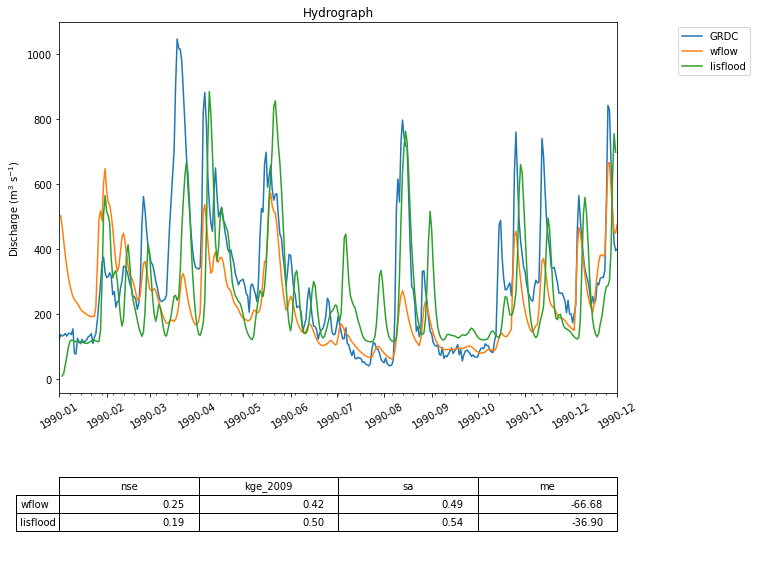

In [23]:
# Combine simulated and observed values to one dataframe according to time axis
hydro_data = pd.concat([wflow, lisflood, observations], axis=1)

# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='GRDC', filename = 'figures\case2_HelloWorldsHydrograph.png')